## 1. Importing libraries

In [3]:
import torch
import gym
import numpy as np
import time
import cv2
import math
import random
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from collections import deque
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import warnings
import os
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, MaxPool2d, ReLU, Flatten, Linear, MSELoss
from torch.optim import Adam, SGD
from torchinfo import summary

In [2]:
warnings.filterwarnings("ignore") # Used to avoid unimportant, annoying warnings while training

## 2. Checking availability of GPU

In [38]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") 
print("Device: ",device)

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn)
    print('Device name:', torch.cuda.get_device_name(0))

Device:  cuda
__CUDNN VERSION: <module 'torch.backends.cudnn' from '/home/mario.cantero/.conda/envs/AIProject/lib/python3.8/site-packages/torch/backends/cudnn/__init__.py'>
Device name: Quadro RTX 6000


## 3. Creating the environment

In [6]:
env_si = gym.make("SpaceInvaders-v0")
env_si.seed(0);

env_c = gym.make("Carnival-v0")
env_c.seed(0);

env_ar = gym.make("AirRaid-v0")
env_ar.seed(0);

## 4. Performance of a random policy

In [10]:
def random_play(game, number_of_episodes):
    for episodes in range(number_of_episodes):
        score = 0
        game.reset()
        while True:
            game.render()
            action = game.action_space.sample()           # Takes a random action from action space
            state, reward, done, info = game.step(action) # Performs that action
            score += reward
            if done:
                game.close()
                print("Your Score at end of game is: ", score)
                break
            time.sleep(0.01)
        game.close()

In [11]:
random_play(env_si, 2)

Your Score at end of game is:  50.0
Your Score at end of game is:  120.0


## 5. Exploring the environments

In [12]:
for env in [env_si, env_c, env_ar]:
    print(f"The size of a {str(env.spec)} frame is: ", env.observation_space.shape)
    print("No. of Actions: ", env.action_space.n)

The size of a EnvSpec(SpaceInvaders-v0) frame is:  (210, 160, 3)
No. of Actions:  6
The size of a EnvSpec(Carnival-v0) frame is:  (214, 160, 3)
No. of Actions:  6
The size of a EnvSpec(AirRaid-v0) frame is:  (250, 160, 3)
No. of Actions:  6


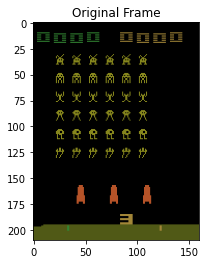

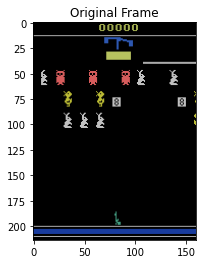

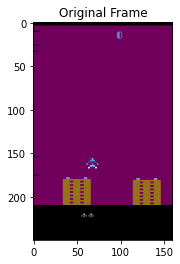

In [13]:
for env in [env_si, env_c, env_ar]:
    env.reset()
    plt.figure()
    plt.imshow(env.reset())
    plt.title('Original Frame')
    plt.show()

## 6. Image preprocessing and stacking frames

#### 6.1 Functions

In [14]:
def preprocess_state(state, game):
    game_name = str(game.spec)
    if game_name == "EnvSpec(SpaceInvaders-v0)":
        # Initially, the image has a shape of (210, 160, 3)
        # Crop and resize the image
        image = state[25:201:2, ::2]

    elif game_name == "EnvSpec(Carnival-v0)":
        # Initially, the image has a shape of (214, 160, 3)
        # Crop and resize the image
        image = state[36:207:2, :158:2]

    elif game_name == "EnvSpec(AirRaid-v0)":
        # Initially, the image has a shape of (250, 160, 3)
        # Crop and resize the image
        image = state[18:210:2, 8::2]

    # Convert rgb image to grayscale
    image = image.mean(axis = 2)
    scaler = MinMaxScaler()
    model = scaler.fit(image)
    image = model.transform(image)

    # Reshape the image
    image = cv2.resize(image,(84, 84),interpolation = cv2.INTER_NEAREST)
    return image

In [17]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames_deque, new_frame, is_new_episode, env):
    # Preprocess frame: cropping and greyscaling
    frame = preprocess_state(new_frame, env_si)
    
    if is_new_episode:
        # Clear our stacked_frames_deque
        stacked_frames_deque = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # We stack the same initial frame four times since it's a new episode
        stacked_frames_deque.append(frame)
        stacked_frames_deque.append(frame)
        stacked_frames_deque.append(frame)
        stacked_frames_deque.append(frame)
        
        # We now stack the four frames from the deque to get a 3-dimensional matrix (84,84,4) for input to our CNN
        stacked_frames = np.stack(stacked_frames_deque, axis=2)
        
    else:
        # First in, first out: deque has a limit of four
        stacked_frames_deque.append(frame)
        
        # We now stack the four frames from the deque to get a 3-dimensional matrix for input to our CNN
        stacked_frames = np.stack(stacked_frames_deque, axis=2) 
    stacked_frames = torch.from_numpy(stacked_frames)
    stacked_frames = torch.reshape(stacked_frames, (1, stacked_frames.shape[2], stacked_frames.shape[0], stacked_frames.shape[1]))    
    
    return stacked_frames, stacked_frames_deque

#### 6.2 Image preview

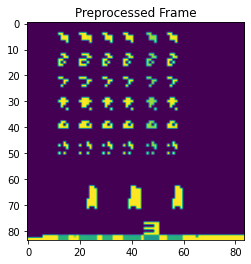

In [18]:
observation = env_si.reset()
observation = preprocess_state(observation, env_si)
plt.figure()
plt.imshow(observation)
plt.title('Preprocessed Frame')
plt.show()

## 7. Neural networks

In [19]:
class DQN(nn.Module):

    def __init__(self, model_path='models/model.pt'):
        super().__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.model_path = model_path

    def build_model(self, n_stacked_frames, n_actions):
        self.n_actions = n_actions
        # Architecture proposed in https://arxiv.org/abs/1312.5602

        self.model = Sequential(OrderedDict([
        ('conv_1', Conv2d(in_channels=n_stacked_frames, out_channels=16, kernel_size=(4, 4), stride=(4, 4))),
        ('activation_1', ReLU()),
        ('conv_2', Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), stride=(2, 2))),
        ('activation_2', ReLU()),
        ('flatten', Flatten()),
        ('linear_1', Linear(in_features=2592, out_features=256)),
        ('activation_4', ReLU()),
        ('linear_2', Linear(in_features=256, out_features=n_actions))]))

        self.model.to(self.device)

        # create model file if not present
        if not os.path.isfile(self.model_path):
            self.save_model()

    def print_model(self):
        print(summary(model=self.model, input_size=(1, 4, 84, 84)))

    def predict(self, state):
        state_tensor = torch.tensor(state)
        return self.model(state_tensor.float().to(device))

    def save_model(self):
        print('Saving model')
        torch.save({
            'state_dict': self.model.state_dict(),
        }, self.model_path)

## 8. The Replay Memory

In [20]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size), size = batch_size, replace = False)
        return [self.buffer[i] for i in index]

    def populating_memory(self, pretrain_length, game):
        for i in range(pretrain_length):
            # First initializing transition
            if i == 0:
                stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
                initial_frame = game.reset()
                stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, initial_frame, True, game)
                
            # Getting a random action from action space
            action = game.action_space.sample()
            next_frame, reward, done, _ = game.step(action)

            # Stack the frames
            next_stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, next_frame, False, game)
        
            # If it's the end of the episode
            if done:
                # End of episode
                next_stacked_frames = np.zeros(stacked_frames.shape)
                
                # Add experience to replay memory
                self.add((stacked_frames, action, reward, next_stacked_frames, done))
                
                # Start a new episode
                initial_frame = game.reset()
                
                # Stack the frames
                stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, initial_frame, True, game)
                
            else:
                # Add experience to replay memory
                self.add((stacked_frames, action, reward, next_stacked_frames, done))
                
                # Update current state
                stacked_frames = next_stacked_frames

## 9. Watching it play before training

In [36]:
def watch_untrained_agent(game, untrained_agent, number_of_episodes):
    scores_per_episode = []
    for i_episodes in range(number_of_episodes):
        score = 0
        initial_frame = game.reset()
        stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, initial_frame, True, game) ############ Here we need the preprocessing function
        counter = 0
        rand_int_frames = random.randint(3,5)
        while True:
            game.render()
            # Random frame skipping
            if counter % rand_int_frames == 0:
                q = untrained_agent.predict(stacked_frames)
                rand_int_frames = random.randint(3,5)
            counter += 1
            a_t = torch.argmax(q)
            q = untrained_agent.predict(stacked_frames)
            a_t = torch.argmax(q) ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy
            next_frame, reward, done, _ = game.step(a_t)
            score += reward
            stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, next_frame, False, game) ########## Here we need the preprocessing function
            time.sleep(0.01)
            if done:
                game.close()
                break
        scores_per_episode.append(score)

In [33]:
action_size = env_si.action_space.n
n_stacked_frames = 4
learning_rate = 0.001

untrained_agent = DQN()
untrained_agent.build_model(n_stacked_frames, action_size)

In [34]:
untrained_agent.print_model()

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─Conv2d: 1-1                            [1, 16, 21, 21]           1,040
├─ReLU: 1-2                              [1, 16, 21, 21]           --
├─Conv2d: 1-3                            [1, 32, 9, 9]             8,224
├─ReLU: 1-4                              [1, 32, 9, 9]             --
├─Flatten: 1-5                           [1, 2592]                 --
├─Linear: 1-6                            [1, 256]                  663,808
├─ReLU: 1-7                              [1, 256]                  --
├─Linear: 1-8                            [1, 6]                    1,542
Total params: 674,614
Trainable params: 674,614
Non-trainable params: 0
Total mult-adds (M): 1.79
Input size (MB): 0.11
Forward/backward pass size (MB): 0.08
Params size (MB): 2.70
Estimated Total Size (MB): 2.89


In [40]:
watch_untrained_agent(env_si, untrained_agent, 1)

## 10. Hyperparameters

In [41]:
def START_seed():
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [15]:
START_seed()
input_shape = (84, 84, 4)
action_size = env_si.action_space.n
n_stacked_frames = 4
gamma = 0.99           # Discount factor
buffer_size = 20000    # Replay buffer size
pretrain_length = 1000 # Number of experiences used to filled an initialiazed memory
learning_rate = 0.001  # Learning rate

# Exploration vs Explotaition tradeoff, epsilon decays over time
eps_start = 0.99        # starting value of epsilon
eps_end = 0.01          # Ending value of epsilon
eps_decay = 800         # Rate by which epsilon to be decayed

## 11. Training the agent

#### 11.1 Decay of epsilon

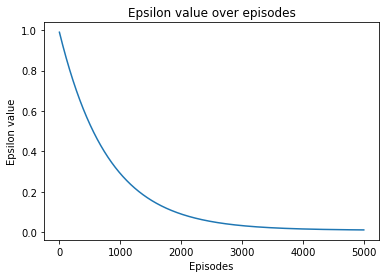

In [79]:
epsilon_by_episode = lambda frame_idx: eps_end + (eps_start - eps_end) * math.exp(-1. * frame_idx /eps_decay)
plt.plot([epsilon_by_episode(i) for i in range(5000)])
plt.title('Epsilon value over episodes')
plt.ylabel('Epsilon value')
plt.xlabel('Episodes')
plt.show()

#### 11.2 Main training algorithm

In [57]:
def train(n_episodes=1000, game=env_si, Q = untrained_agent, buffer_size=20000, pretrain_length=1000, gamma=0.99, learning_rate=0.001):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    game_name = str(game.spec)
    loss_window = []
    scores = []
    scores_window = deque(maxlen=20)
    frames_deque = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
    ########### Initialize replay memory D to capacity N (most of the sources indicate that N should be 1 million)
    memory = Memory(buffer_size)
    memory.populating_memory(pretrain_length, game)
    ########### Initialize target action-value function Q_hat with weights Theta_ = Theta
    Q_hat = DQN()
    Q_hat.build_model(n_stacked_frames, action_size)
    Q_hat.load_state_dict(Q.state_dict())
    
    optimizer = SGD(lr=learning_rate, params=Q.parameters())
    loss = MSELoss()
    
    start_time = time.time()
    
    for i_episode in range(1, n_episodes+1):
        loss_list = []
        avg_loss = 0
        initial_frame = game.reset()
        stacked_frames, frames_deque = stack_frames(frames_deque, initial_frame, True, game)
        score = 0
        eps = epsilon_by_episode(i_episode)
        C = 0
        counter = 0
        rand_int_frames = random.randint(3,5)
        
        if "SpaceInvaders" in game_name:
            for nopes in range(50):
                new_frame, _, _, _ = game.step(0) # Nope
                stacked_frames, frames_deque = stack_frames(frames_deque, new_frame, False, game)
        
        K = random.randint(10,20)
        
        for _ in range(K):
            rand_init_state_action = random.randint(2,3)
            new_frame, _, _, _ = game.step(rand_init_state_action)
            stacked_frames, frames_deque = stack_frames(frames_deque, new_frame, False, game)
            
        while True:
            #### Random frame skipping
            if counter % rand_int_frames == 0:
                if random.random() <= eps:
                    selected_a_t = game.action_space.sample()
                else:
                    q = Q.predict(stacked_frames) # Feedforward propagation
                    selected_a_t = torch.argmax(q)
                rand_int_frames = random.randint(3,5)
            counter += 1
            ####
            
            action = selected_a_t ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy

            next_frame, reward, done, _ = game.step(action)
            
            next_stacked_frames, frames_deque = stack_frames(frames_deque, next_frame, False, game)
            
            ############### Here we store the transition (phi_(t), a_(t), r_(t), phi_(t+1)) in D
            memory.add((stacked_frames, action, reward, next_stacked_frames, done))
            
            ################# Training phase ######################
            ####### 1.- Sample random minibatch with uniform distribution of transitions (phi_(j), a_(j), r_(j), phi_(j+1)) from D
            minibatch = memory.sample(16)
            
            ####### 2.- Calculate the target value "y"
            
            target_q_values = torch.tensor([], requires_grad=True).to(device)
            predictions = torch.tensor([], requires_grad=True).to(device)

            for s_t, a_t, r_t, s_t1, done in minibatch:
                q_hat_s_t1 = Q_hat.predict(s_t1)  # Predicted Q values for the next state
                target = Q.predict(s_t)  # Predicted Q values

                new_target = torch.tensor([r_t + (1 - done) * gamma * torch.max(q_hat_s_t1)]).to(device)
                predicted_q_value = torch.tensor(target[0, a_t]).to(device)
                predicted_q_value = predicted_q_value.unsqueeze(0)
                
                target_q_values = torch.cat((target_q_values, new_target), dim=0)
                predictions = torch.cat((predictions, predicted_q_value), dim=0)
            
            loss_computation = loss(predictions, target_q_values)
            optimizer.zero_grad()
            loss_computation.backward()
            optimizer.step()
            loss_test = loss_computation.item()
            
            loss_list.append(loss_computation.tolist())
            avg_loss = np.mean(loss_list)

            stacked_frames = next_stacked_frames
            score += reward
            
            ############### Every C steps reset Q_hat = Q, we train only on Q
            if C % 15 == 0:
                Q_hat.load_state_dict(Q.state_dict())
            if done:
                break
        
        loss_window.append(avg_loss)
        scores_window.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Plotting
        if i_episode % 100 == 0:
            print('Saving model')
            torch.save({'state_dict': Q.model.state_dict()}, '/home/mario.cantero/AI701Project_MNM_RL/agent_final.pt')
            with open("scores_final.txt", "w") as f:
                for s in scores:
                    f.write(str(s) +"\n")
            with open("loss_final.txt", "w") as f:
                for l in loss_window:
                    f.write(str(l) +"\n")
            
            #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            #fig = plt.figure()
            #ax = fig.add_subplot(111)
            #plt.plot(np.arange(len(scores)), scores)
            #plt.ylabel('Score')
            #plt.xlabel('Episode #')
            #plt.show()
            
            #print('\rEpisode {}\tAverage Loss: {:.2f}'.format(i_episode, avg_loss))
            #fig = plt.figure()
            #ax = fig.add_subplot(111)
            #plt.plot(np.arange(len(loss_window)), loss_window)
            #plt.ylabel('Loss')
            #plt.xlabel('Episode #')
            #plt.show()
    print("--- %s seconds ---" % round(time.time() - start_time, 2))
    return Q, memory, scores, loss_window

In [ ]:
untrained_agent = DQN()
untrained_agent.build_model(n_stacked_frames, action_size)

In [58]:
agent, memory, scores, loss_window = train(n_episodes=5000, game=env_si, Q = untrained_agent, buffer_size=20000, pretrain_length=1000, gamma=0.99, learning_rate=0.001):

Episode 100	Average Score: 3.25Saving model
Episode 200	Average Score: 10.75Saving model
Episode 300	Average Score: 31.50Saving model
Episode 400	Average Score: 7.25Saving model
Episode 500	Average Score: 12.25Saving model
Episode 600	Average Score: 5.25Saving model
Episode 700	Average Score: 13.75Saving model
Episode 800	Average Score: 22.75Saving model
Episode 900	Average Score: 7.00Saving model
Episode 1000	Average Score: 5.75Saving model
Episode 1100	Average Score: 10.00Saving model
Episode 1200	Average Score: 11.75Saving model
Episode 1300	Average Score: 3.00Saving model
Episode 1400	Average Score: 15.50Saving model
Episode 1500	Average Score: 15.00Saving model
Episode 1600	Average Score: 8.00Saving model
Episode 1700	Average Score: 10.75Saving model
Episode 1800	Average Score: 4.50Saving model
Episode 1900	Average Score: 7.50Saving model
Episode 2000	Average Score: 6.25Saving model
Episode 2100	Average Score: 7.00Saving model
Episode 2200	Average Score: 5.50Saving model
Episode 2

# RESULTS

## 12. Loading the model, scores, and loss

#### Space Invaders

scores = []
with open("scores.txt", "r") as f:
    for line in f:
        scores.append(float(line.strip()))
scores[0] = 0

In [82]:
scores_cumulative = np.cumsum(np.array(scores))/range(1,len(scores)+1)

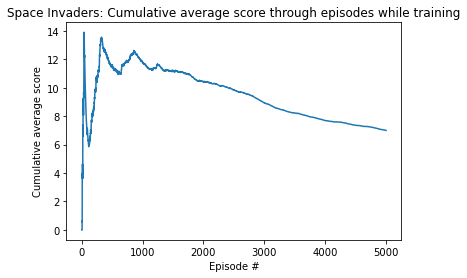

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(scores_cumulative.shape[0]), scores_cumulative)
plt.title('Space Invaders: Cumulative average score through episodes while training')
plt.ylabel('Cumulative average score')
plt.xlabel('Episode #')
plt.show()

loss = []
with open("loss_final.txt", "r") as f:
    for line in f:
        scores.append(float(line.strip()))

In [75]:
loss_cumulative = np.cumsum(np.array(loss_window))/range(1,len(loss_window)+1)

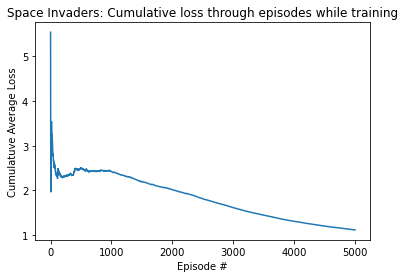

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(loss_cumulative.shape[0]), loss_cumulative)
plt.title('Space Invaders: Cumulative loss through episodes while training')
plt.ylabel('Cumulatuve Average Loss')
plt.xlabel('Episode #')
plt.show()

#### Carnival

In [96]:
scores_carnival = []
with open("scores_carnival.txt", "r") as f:
    for line in f:
        scores_carnival.append(float(line.strip()))
        
scores_carnival[0] = 0

In [103]:
scores_cumulative_carnival = np.cumsum(np.array(scores_carnival))/range(1,len(scores_carnival)+1)

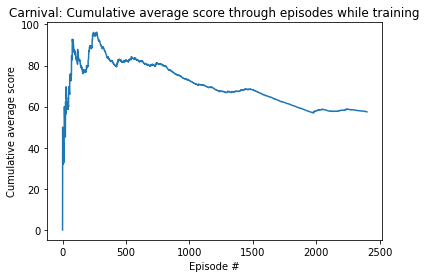

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(scores_cumulative_carnival.shape[0]), scores_cumulative_carnival)
plt.title('Carnival: Cumulative average score through episodes while training')
plt.ylabel('Cumulative average score')
plt.xlabel('Episode #')
plt.show()

In [106]:
loss_carnival = []
with open("loss_carnival.txt", "r") as f:
    for line in f:
        loss_carnival.append(float(line.strip()))

In [107]:
loss_cumulative_carnival = np.cumsum(np.array(loss_carnival))/range(1,len(loss_carnival)+1)

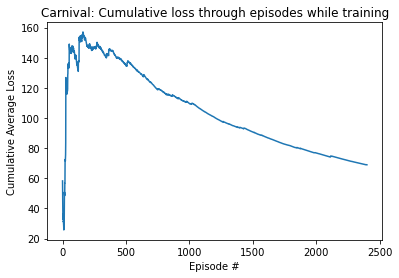

In [173]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(loss_cumulative_carnival.shape[0]), loss_cumulative_carnival)
plt.title('Carnival: Cumulative loss through episodes while training')
plt.ylabel('Cumulative Average Loss')
plt.xlabel('Episode #')
plt.show()

#### Air Raid

In [177]:
scores_airraid = []
with open("scores_airraid.txt", "r") as f:
    for line in f:
        scores_airraid.append(float(line.strip()))
        
scores_airraid = scores_airraid[3:]

In [183]:
scores_cumulative_airraid = np.cumsum(np.array(scores_airraid))/range(1,len(scores_airraid)+1)

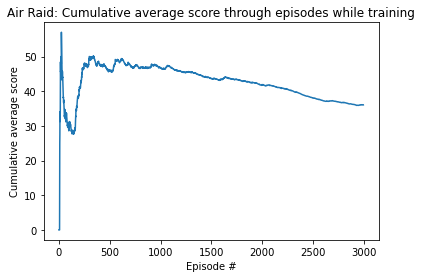

In [184]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(scores_cumulative_airraid.shape[0]), scores_cumulative_airraid)
plt.title('Air Raid: Cumulative average score through episodes while training')
plt.ylabel('Cumulative average score')
plt.xlabel('Episode #')
plt.show()

In [185]:
loss_airraid = []
with open("loss_airraid.txt", "r") as f:
    for line in f:
        loss_airraid.append(float(line.strip()))

In [186]:
loss_cumulative_airraid = np.cumsum(np.array(loss_airraid))/range(1,len(loss_airraid)+1)

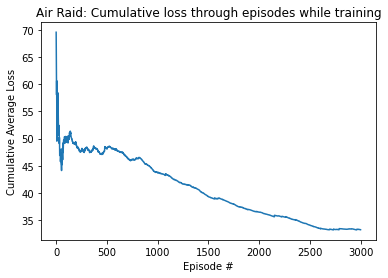

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(loss_cumulative_airraid.shape[0]), loss_cumulative_airraid)
plt.title('Air Raid: Cumulative loss through episodes while training')
plt.ylabel('Cumulative Average Loss')
plt.xlabel('Episode #')
plt.show()

## 13. Evaluate the agent

In [151]:
def evaluate_frame_skipping(game, agent, number_of_episodes):
    scores_per_episode = []
    for i_episodes in range(number_of_episodes):
        score = 0
        initial_frame = game.reset()
        stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, initial_frame, True, game) ############ Here we need the preprocessing function
        counter = 0
        rand_int_frames = random.randint(3,5)
        while True:
            # Random frame skipping
            if counter % rand_int_frames == 0:
                q = agent.predict(stacked_frames)
                rand_int_frames = random.randint(3,5)
            counter += 1
            a_t = torch.argmax(q)
            q = agent.predict(stacked_frames)
            a_t = torch.argmax(q) ###### Action selected by the action-value function Q (neural network) with epsilon greedy policy
            next_frame, reward, done, _ = game.step(a_t)
            score += reward
            stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, next_frame, False, game) ########## Here we need the preprocessing function
            if done:
                break
        scores_per_episode.append(score)
    return scores_per_episode

def watch(game, agent):
    score = 0
    initial_frame = game.reset()
    stacked_frames_deque  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
    stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, initial_frame, True, game) ############ Here we need the preprocessing function
    while True:
        time.sleep(0.01)
        game.render()
        q = agent.predict(stacked_frames)
        a_t = torch.argmax(q)
        next_frame, reward, done, _ = game.step(a_t)
        score += reward
        stacked_frames, stacked_frames_deque = stack_frames(stacked_frames_deque, next_frame, False, game) ########## Here we need the preprocessing function
        if done:
            break
    game.close()
    print('Your final score is:', score)
    
def random_policy_agent(game, number_of_episodes):
    scores_per_episode = []
    for episodes in range(number_of_episodes):
        score = 0
        game.reset()
        while True:
            action = game.action_space.sample()
            state, reward, done, info = game.step(action)
            score += reward
            if done:
                break
        scores_per_episode.append(score)
    return scores_per_episode

### Space Invaders

##### Intelligent agent

In [24]:
agent_space_invaders_final = DQN()
agent_space_invaders_final.build_model(n_stacked_frames, action_size)
agent_space_invaders_final.model.load_state_dict(torch.load('/home/mario.cantero/AI701Project_MNM_RL/agent_space_invaders_final.pt')['state_dict'])

<All keys matched successfully>

In [152]:
scores_eval_spaceinvaders_fs = evaluate_frame_skipping(env_si, agent_space_invaders_final, 500)

In [197]:
watch(env_si, agent_space_invaders_final)

Your final score is: 280.0


In [121]:
env_si.close()

##### Agent with a random policy

In [120]:
scores_eval_spaceinvaders_random = random_policy_agent(env_si, 500)

##### Comparison

In [158]:
df_si = pd.DataFrame(data={'Intelligent Agent with FS': scores_eval_spaceinvaders_fs,
                           'Agent with random policy': scores_eval_spaceinvaders_random})
df_si_plot = df_si.reset_index().melt('index', var_name='Agent', value_name='Scores').copy()

In [159]:
df_si.describe().round(2)

,Intelligent Agent with FS,Agent with random policy
count,500.00,500.00
mean,190.96,149.78
std,124.27,95.96
min,10.00,5.00
25%,95.00,80.00
50%,155.00,130.00
75%,260.00,187.50
max,705.00,560.00


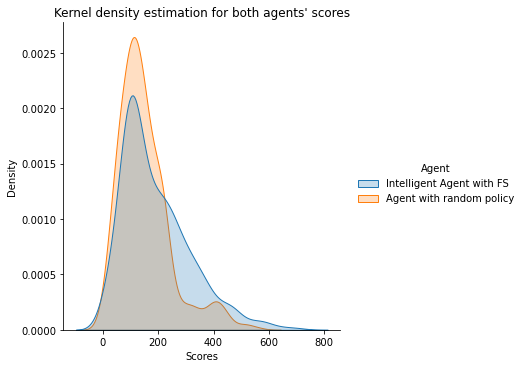

In [217]:
sns.displot(df_si_plot, x="Scores", hue="Agent", 
            kind="kde", fill=True).set(title='Kernel density estimation for both agents\' scores')

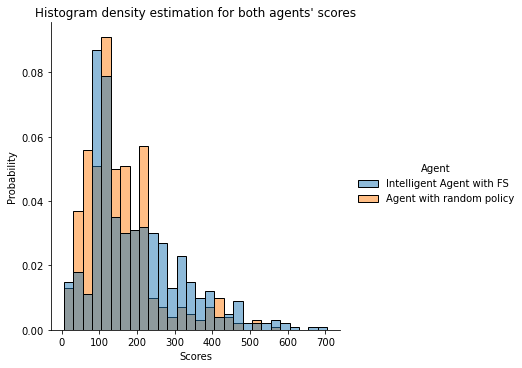

In [218]:
sns.displot(df_si_plot, x="Scores", hue="Agent", 
            stat="probability").set(title='Histogram density estimation for both agents\' scores')

In [157]:
stats.kstest(scores_eval_spaceinvaders_fs, scores_eval_spaceinvaders_random)

KstestResult(statistic=0.2, pvalue=3.6740572722559346e-09)

### Carnival

##### Intelligent agent

In [188]:
agent_carnival_final = DQN()
agent_carnival_final.build_model(n_stacked_frames, action_size)
agent_carnival_final.model.load_state_dict(torch.load('/home/mario.cantero/AI701Project_MNM_RL/agent_carnival.pt')['state_dict'])

<All keys matched successfully>

In [189]:
agent_carnival_final_2 = DQN()
agent_carnival_final_2.build_model(n_stacked_frames, action_size)
agent_carnival_final_2.model.load_state_dict(torch.load('/home/mario.cantero/AI701Project_MNM_RL/agent_neg_reward_carnival.pt')['state_dict'])

<All keys matched successfully>

In [198]:
scores_eval_carnival_fs = evaluate_frame_skipping(env_c, agent_carnival_final, 500)

In [195]:
watch(env_c, agent_carnival_final_2)

Your final score is: 260.0


In [199]:
env_c.close()

##### Agent with a random policy

In [200]:
scores_eval_carnival_random = random_policy_agent(env_c, 500)

##### Comparison

In [201]:
df_c = pd.DataFrame(data={'Intelligent Agent with FS': scores_eval_carnival_fs,
                           'Agent with random policy': scores_eval_carnival_random})
df_c_plot = df_c.reset_index().melt('index', var_name='Agent', value_name='Scores').copy()

In [202]:
df_c.describe().round(2)

,Intelligent Agent with FS,Agent with random policy
count,500.00,500.00
mean,614.84,768.72
std,275.17,365.13
min,0.00,40.00
25%,440.00,500.00
50%,600.00,680.00
75%,765.00,920.00
max,1960.00,2760.00


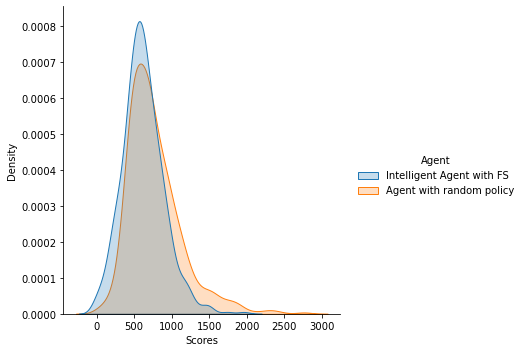

In [203]:
sns.displot(df_c_plot, x="Scores", hue="Agent", kind="kde", fill=True)

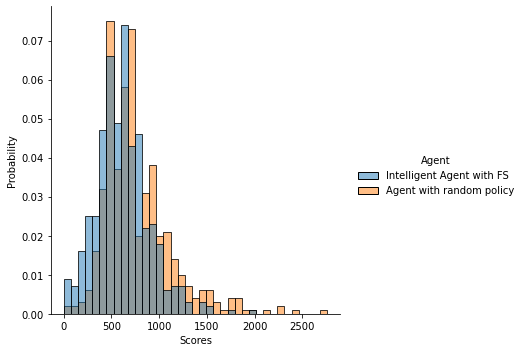

In [204]:
sns.displot(df_c_plot, x="Scores", hue="Agent", stat="probability")

In [205]:
stats.kstest(scores_eval_carnival_fs, scores_eval_carnival_random)

KstestResult(statistic=0.174, pvalue=5.009206937519233e-07)

### Air Raid

##### Intelligent agent

In [206]:
agent_airraid_final = DQN()
agent_airraid_final.build_model(n_stacked_frames, action_size)
agent_airraid_final.model.load_state_dict(torch.load('/home/mario.cantero/AI701Project_MNM_RL/agent_airraid_final.pt')['state_dict'])

<All keys matched successfully>

In [207]:
scores_eval_airraid_fs = evaluate_frame_skipping(env_ar, agent_airraid_final, 500)

In [195]:
watch(env_ar, agent_airraid_final)

Your final score is: 260.0


In [208]:
env_ar.close()

##### Agent with a random policy

In [209]:
scores_eval_airraid_random = random_policy_agent(env_ar, 500)

##### Comparison

In [210]:
df_ar = pd.DataFrame(data={'Intelligent Agent with FS': scores_eval_airraid_fs,
                           'Agent with random policy': scores_eval_airraid_random})
df_ar_plot = df_ar.reset_index().melt('index', var_name='Agent', value_name='Scores').copy()

In [211]:
df_ar.describe().round(2)

,Intelligent Agent with FS,Agent with random policy
count,500.00,500.00
mean,707.05,608.60
std,446.50,393.33
min,0.00,0.00
25%,400.00,350.00
50%,600.00,500.00
75%,900.00,800.00
max,2675.00,2450.00


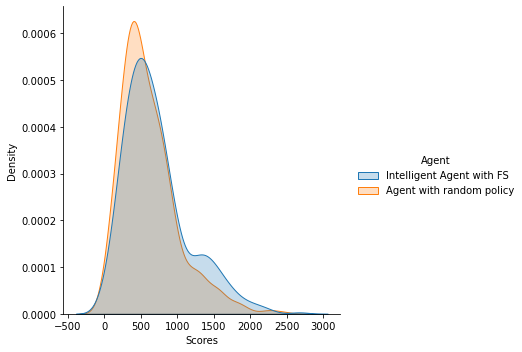

In [212]:
sns.displot(df_ar_plot, x="Scores", hue="Agent", kind="kde", fill=True)

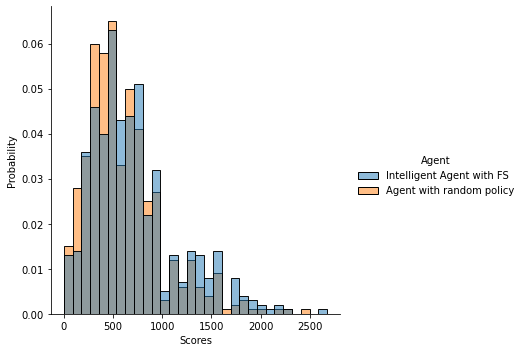

In [213]:
sns.displot(df_ar_plot, x="Scores", hue="Agent", stat="probability")

In [214]:
stats.kstest(scores_eval_airraid_fs, scores_eval_airraid_random)

KstestResult(statistic=0.118, pvalue=0.0018769751767371433)